## **0. IMPORTS, SOURCES AND FUNCTIONS**

### 0.1. IMPORTS

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from boruta import BorutaPy
from xgboost import XGBRegressor
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

### 0.2. EXTERNAL SOURCES AND LINKS

This section contemplates only data sources. Other sources might be included throughout the notebook.

https://www.mavenanalytics.io/data-playground?search=super%20bowl

https://public.opendatasoft.com/explore/dataset/super-bowl/table/?sort=date&rows=60

https://www.sportsmediawatch.com/super-bowl-ratings-historical-viewership-chart-cbs-nbc-fox-abc/

### 0.3. FUNCTIONS

In [2]:
# https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook

def cramers_V(var1,var2):
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [3]:
def build_cramersv_dataframe(dataframe):
    correlation_dataframe = pd.DataFrame(index = dataframe.columns, columns = dataframe.columns)
    for i in dataframe.columns:
        for j in dataframe.columns:
            correlation_dataframe.loc[j,i] = cramers_V(dataframe[j], dataframe[i])
    for i in correlation_dataframe.columns:
        correlation_dataframe[i] = correlation_dataframe[i].astype(float)
    return correlation_dataframe

In [4]:
def error_measures(model, y_test, predictions):
    response = dict(MAE = mean_absolute_error(y_test, predictions),
                    RMSE = np.sqrt(mean_squared_error(y_test, predictions)),
                    MPE = np.mean(np.abs(y_test - predictions) / y_test * 100))
    return pd.DataFrame(response, index = [model])

## **1. DATA COLLECTION AND DESCRIPTION**

### 1.1. Load and check first file

In [6]:
df1.columns = df1.iloc[1]
df1.drop([0,1], axis = 0, inplace = True)
df1 = df1[['Year', 'Net', 'Rtg', 'TV Vwrs']]
df1.columns = ['Year', 'Net', 'Rtg','Rtg1', 'TV Vwrs']
df1.drop('Rtg1', axis = 1, inplace = True)
df1.sample(10)

Year  Net   Rtg  TV Vwrs
27  1997  FOX  43.3   87.87M
18  2006  ABC  41.6   90.75M
50  1974  CBS  41.6   51.70M
8   2016  CBS  46.6  111.86M
42  1982  CBS  49.1   85.24M
40  1984  CBS  46.4   77.62M
13  2011  FOX  46.0  111.01M
39  1985  ABC  46.4   85.53M
58  1967  NBC  18.5   24.43M
28  1996  NBC  46.0   94.08M

In [5]:
df1 = pd.read_html("https://www.sportsmediawatch.com/super-bowl-ratings-historical-viewership-chart-cbs-nbc-fox-abc/")
df1 = df1[0]
df1.head()

0        1       2    3        4        5              6        7   \
0  Year     Game  Margin  Net  Overall  Overall        Overall  Overall   
1  Year     Game  Margin  Net      Rtg  TV Vwrs           Strm    Spnsh   
2  2022  LAR-CIN  LAR +3  NBC     36.9   99.18M  6.0M (11.2M*)     1.9M   
3  2021    TB-KC  TB +22  CBS     38.2  91.63M*           5.7M     647K   
4  2020    KC-SF  KC +11  FOX     41.6  100.45M           3.4M     757K   

        8       9       10  
0  Overall  A18-49  A18-49  
1      OOH     Rtg    Vwrs  
2    incl.    29.5  38.45M  
3    incl.    26.5  34.28M  
4      13M    29.9  38.67M

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 2 to 58
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     57 non-null     object
 1   Net      57 non-null     object
 2   Rtg      57 non-null     object
 3   TV Vwrs  57 non-null     object
dtypes: object(4)
memory usage: 1.9+ KB


### 1.2. Load and check second file

In [8]:
df2 = pd.read_csv('csv files/super-bowl.csv', parse_dates = ['Date'], date_parser = pd.to_datetime, sep=';')
df2.sample(3)

Date    SB  Attendance                Winner      QB  Winner  \
34 1972-01-16    VI       81023        Dallas Cowboys  Roger Staubach   
47 2019-02-03  LIII       70081  New England Patriots       Tom Brady   
2  1985-01-20   XIX       84059   San Francisco 49ers     Joe Montano   

      Coach Winner  Winning Pts             Loser    QB Loser Coach Loser  \
34      Tom Landry           24    Miami Dolphins  Bob Griese   Don Shula   
47  Bill Belichick           13  Los Angeles Rams  Jared Goff  Sean McVay   
2       Bill Walsh           38    Miami Dolphins  Dan Marino   Don Shula   

    ...  Point Difference       Referee       Umpire Head Linesman  \
34  ...                21    Jim Tunney  Joe Connell     Al Sabato   
47  ...                10    John Parry   Fred Bryan       Ed Camp   
2   ...                22  Pat Haggerty  Tom Hensley     Leo Miles   

      Line Judge   Field Judge        Back Judge   Side Judge  \
34     Art Holst   Bob Wortman  Ralph Vandenberg          NaN   
47  Jeff Bergman  Steve Zimmer    Terrence Miles  Eugene Hall   
2      Ray Dodez     Bob Lewis      Tom Kelleher  Bill Quinby   

                                            Geo Shape  \
34  {"coordinates": [[[-89.21767, 29.29108], [-89....   
47  {"coordinates": [[[-80.8650068835, 32.03316132...   
2   {"coordinates": [[[-114.3549006824, 34.4646666...   

                    Geo Point 2D  
34  31.0480777894,-91.9572061819  
47  32.6524688988,-83.4510929921  
2   37.2551445335,-119.640543961  

[3 rows x 25 columns]

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              54 non-null     datetime64[ns]
 1   SB                54 non-null     object        
 2   Attendance        54 non-null     int64         
 3   Winner            54 non-null     object        
 4   QB  Winner        54 non-null     object        
 5   Coach Winner      54 non-null     object        
 6   Winning Pts       54 non-null     int64         
 7   Loser             54 non-null     object        
 8   QB Loser          54 non-null     object        
 9   Coach Loser       54 non-null     object        
 10  Losing Pts        54 non-null     int64         
 11  MVP               54 non-null     object        
 12  Stadium           54 non-null     object        
 13  City              54 non-null     object        
 14  State             54 non-nul

### 1.3. Merge dataframes

In [10]:
# Create columns to merge

df2['Year'] = df2['Date'].apply(lambda x: x.year)
df1['Year'] = df1['Year'].astype('int16')

In [11]:
df1 = pd.merge(df1, df2, on="Year", how='left')
df1.sample(3)

Year  Net   Rtg TV Vwrs       Date    SB  Attendance               Winner  \
39  1983  NBC  48.6  81.77M 1983-01-30  XVII    103667.0  Washington Redskins   
48  1974  CBS  41.6  51.70M 1974-01-13  VIII     71882.0       Miami Dolphins   
45  1977  NBC  44.4  62.05M 1977-01-09    XI    103438.0      Oakland Raiders   

       QB  Winner Coach Winner  ...  Point Difference          Referee  \
39  Joe Theismann    Joe Gibbs  ...              10.0  Jerry Markbreit   
48     Bob Griese    Don Shula  ...              17.0       Ben Dreith   
45  Kenny Stabler  John Madden  ...              18.0       Jim Tunney   

            Umpire Head Linesman     Line Judge    Field Judge    Back Judge  \
39      Art Demmas    Dale Hamer  Bill Reynolds        Don Orr   Dick Hantak   
48  Ralph Morcroft     Leo Miles     Jack Fette     Fritz Graf    Stan Javie   
45     Lou Palazzi     Ed Marion   Bill Swanson  Armen Terzian  Tom Kelleher   

    Side Judge                                          Geo Shape  \
39  Dave Parry  {"coordinates": [[[-114.3549006824, 34.4646666...   
48         NaN  {"coordinates": [[[-93.5782360502, 31.21613108...   
45         NaN  {"coordinates": [[[-114.3549006824, 34.4646666...   

                    Geo Point 2D  
39  37.2551445335,-119.640543961  
48   31.4555082562,-99.328675661  
45  37.2551445335,-119.640543961  

[3 rows x 29 columns]

### 1.4. Dataframe check

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              57 non-null     int16         
 1   Net               57 non-null     object        
 2   Rtg               57 non-null     object        
 3   TV Vwrs           57 non-null     object        
 4   Date              55 non-null     datetime64[ns]
 5   SB                55 non-null     object        
 6   Attendance        55 non-null     float64       
 7   Winner            55 non-null     object        
 8   QB  Winner        55 non-null     object        
 9   Coach Winner      55 non-null     object        
 10  Winning Pts       55 non-null     float64       
 11  Loser             55 non-null     object        
 12  QB Loser          55 non-null     object        
 13  Coach Loser       55 non-null     object        
 14  Losing Pts        55 non-nul

In [13]:
df1.describe()

Year     Attendance  Winning Pts  Losing Pts  Point Difference
count    57.000000      55.000000    55.000000   55.000000         55.000000
mean   1994.017544   76766.418182    30.200000   16.090909         14.109091
std      16.568571   10526.170071     9.698033    7.391869         10.327369
min    1967.000000   61946.000000    13.000000    3.000000          1.000000
25%    1980.000000   71056.000000    23.500000   10.000000          5.500000
50%    1994.000000   73818.000000    31.000000   17.000000         12.000000
75%    2008.000000   79835.500000    35.000000   21.000000         19.000000
max    2022.000000  103985.000000    55.000000   33.000000         45.000000

## **2. DATA CLEANING**

In [13]:
df2 = df1.copy()

### 2.1. Null values

In [14]:
# Most of the null values are from columns which should not help much with the model, and therefore will be dropped
# soon: Referee, Umpire, Head Linesman, Line Judge, Field Judge, Back Judge, Side Judge, Geo Shape and Geo Point 2D.

df2[df2.isna().any(axis=1)]

Year  Net   Rtg  TV Vwrs       Date    SB  Attendance  \
0   2022  NBC  36.9   99.18M        NaT   NaN         NaN   
1   2021  CBS  38.2  91.63M*        NaT   NaN         NaN   
44  1978  CBS  47.2   78.94M 1978-01-15   XII     76400.0   
45  1977  NBC  44.4   62.05M 1977-01-09    XI    103438.0   
46  1976  CBS  42.3   57.71M 1976-01-18     X     80187.0   
47  1975  NBC  42.4   56.05M 1975-01-12    IX     80997.0   
48  1974  CBS  41.6   51.70M 1974-01-13  VIII     71882.0   
49  1973  NBC  42.7   53.32M 1973-01-14   VII     90182.0   
50  1972  CBS  44.2   56.64M 1972-01-16    VI     81023.0   
51  1971  NBC  39.9   46.04M 1971-01-17     V     79204.0   
52  1970  CBS  39.4   44.27M 1970-01-11    IV     80562.0   
53  1969  NBC  36.0   41.66M 1969-01-12   III     75389.0   
54  1968  CBS  36.8   39.12M 1968-01-14    II     75546.0   
55  1967  CBS  22.6   26.75M 1967-01-15     I     61946.0   
56  1967  NBC  18.5   24.43M 1967-01-15     I     61946.0   

                 Winner                    QB  Winner    Coach Winner  ...  \
0                   NaN                           NaN             NaN  ...   
1                   NaN                           NaN             NaN  ...   
44       Dallas Cowboys                Roger Staubach      Tom Landry  ...   
45      Oakland Raiders                 Kenny Stabler     John Madden  ...   
46  Pittsburgh Steelers                Terry Bradshaw      Chuck Noll  ...   
47  Pittsburgh Steelers                Terry Bradshaw      Chuck Noll  ...   
48       Miami Dolphins                    Bob Griese       Don Shula  ...   
49       Miami Dolphins                    Bob Griese       Don Shula  ...   
50       Dallas Cowboys                Roger Staubach      Tom Landry  ...   
51      Baltimore Colts  Earl Morrall , Johnny Unitas  Don McCafferty  ...   
52   Kansas City Chiefs   Len Dawson, Mike Livingston      Hank Stram  ...   
53        New York Jets                    Joe Namath     Weeb Ewbank  ...   
54    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   
55    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   
56    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   

    Point Difference         Referee          Umpire Head Linesman  \
0                NaN             NaN             NaN           NaN   
1                NaN             NaN             NaN           NaN   
44              17.0      Jim Tunney     Joe Connell   Tony Veteri   
45              18.0      Jim Tunney     Lou Palazzi     Ed Marion   
46               4.0  Norm Schachter     Joe Connell     Leo Miles   
47              10.0    Bernie Ulman       Al Conway     Ed Marion   
48              17.0      Ben Dreith  Ralph Morcroft     Leo Miles   
49               7.0        Tom Bell     Lou Palazzi   Tony Veteri   
50              21.0      Jim Tunney     Joe Connell     Al Sabato   
51               3.0  Norm Schachter  Paul Trepinski     Ed Marion   
52              16.0             NaN             NaN           NaN   
53               9.0             NaN             NaN           NaN   
54              19.0             NaN             NaN           NaN   
55              25.0             NaN             NaN           NaN   
56              25.0             NaN             NaN           NaN   

      Line Judge    Field Judge        Back Judge Side Judge  \
0            NaN            NaN               NaN        NaN   
1            NaN            NaN               NaN        NaN   
44     Art Holst    Bob Wortman       Ray Douglas        NaN   
45  Bill Swanson  Armen Terzian      Tom Kelleher        NaN   
46    Jack Fette   Bill O'Brien        Stan Javie        NaN   
47  Bruce Alford    Dick Dolack       Ray Douglas        NaN   
48    Jack Fette     Fritz Graf        Stan Javie        NaN   
49  Bruce Alford    Tony Skover      Tom Kelleher        NaN   
50     Art Holst    Bob Wortman  Ralph Vandenberg        NaN   
51    Jack Fette 

In [15]:
# Two of the rows have almost all null values (years 2021 e 2022). These rows which did not have any information
# on the second source table. These will be filled in manually. 

df2[df2['Date'].isna()]

Year  Net   Rtg  TV Vwrs Date   SB  Attendance Winner QB  Winner  \
0  2022  NBC  36.9   99.18M  NaT  NaN         NaN    NaN        NaN   
1  2021  CBS  38.2  91.63M*  NaT  NaN         NaN    NaN        NaN   

  Coach Winner  ...  Point Difference Referee Umpire Head Linesman  \
0          NaN  ...               NaN     NaN    NaN           NaN   
1          NaN  ...               NaN     NaN    NaN           NaN   

   Line Judge Field Judge Back Judge Side Judge Geo Shape  Geo Point 2D  
0         NaN         NaN        NaN        NaN       NaN           NaN  
1         NaN         NaN        NaN        NaN       NaN           NaN  

[2 rows x 29 columns]

In [16]:
df2.loc[df2['Year'] == 2021,'Date'] = '2021-02-07'
df2.loc[df2['Year'] == 2021,'SB'] = 'LV'
df2.loc[df2['Year'] == 2021,'Attendance'] = '24835' #Covid restrictions. For more: https://www.scotsman.com/arts-and-culture/film-and-tv/how-many-fans-were-super-bowl-2021-why-nfl-supporters-were-allowed-stadium-amid-covid-restrictions-3127473
df2.loc[df2['Year'] == 2021,'Winner'] = 'Tampa Bay Buccaneers'
df2.loc[df2['Year'] == 2021,'QB  Winner'] = 'Tom Brady'
df2.loc[df2['Year'] == 2021,'Coach Winner'] = 'Bruce Arians'
df2.loc[df2['Year'] == 2021,'Winning Pts'] = '31'
df2.loc[df2['Year'] == 2021,'Loser'] = 'Kansas City Chiefs'
df2.loc[df2['Year'] == 2021,'QB Loser'] = 'Patrick Mahomes'
df2.loc[df2['Year'] == 2021,'Coach Loser'] = 'Andy Reid'
df2.loc[df2['Year'] == 2021,'Losing Pts'] = '9'
df2.loc[df2['Year'] == 2021,'MVP'] = 'Tom Brady'
df2.loc[df2['Year'] == 2021,'Stadium'] = 'Raymond James Stadium'
df2.loc[df2['Year'] == 2021,'City'] = 'Tampa'
df2.loc[df2['Year'] == 2021,'State'] = 'Florida'
df2.loc[df2['Year'] == 2021,'Point Difference'] = '22'
df2.loc[df2['Year'] == 2021,'Geo Point 2D'] = '27.975833,-82.503333'

In [17]:
df2.loc[df2['Year'] == 2022,'Date'] = '2022-02-13'
df2.loc[df2['Year'] == 2022,'SB'] = 'LVI'
df2.loc[df2['Year'] == 2022,'Attendance'] = '70048'
df2.loc[df2['Year'] == 2022,'Winner'] = 'Los Angeles Rams'
df2.loc[df2['Year'] == 2022,'QB  Winner'] = 'Matthew Stafford'
df2.loc[df2['Year'] == 2022,'Coach Winner'] = 'Sean McVay'
df2.loc[df2['Year'] == 2022,'Winning Pts'] = '23'
df2.loc[df2['Year'] == 2022,'Loser'] = 'Cincinnati Bengals'
df2.loc[df2['Year'] == 2022,'QB Loser'] = 'Joe Burrow'
df2.loc[df2['Year'] == 2022,'Coach Loser'] = 'Zac Taylor'
df2.loc[df2['Year'] == 2022,'Losing Pts'] = '20'
df2.loc[df2['Year'] == 2022,'MVP'] = 'Cooper Kupp'
df2.loc[df2['Year'] == 2022,'Stadium'] = 'SoFi Stadium'
df2.loc[df2['Year'] == 2022,'City'] = 'Inglewood'
df2.loc[df2['Year'] == 2022,'State'] = 'California'
df2.loc[df2['Year'] == 2022,'Point Difference'] = '3'
df2.loc[df2['Year'] == 2022,'Geo Point 2D'] = '33.953333,-118.338889'

### 2.2. Data filtering

#### 2.2.1 Rows

In [18]:
# The first Super Bowl was in 1967 and, for some reason it was displayed on TV on two different networks. 

df2[df2['Year'] == 1967]

Year  Net   Rtg TV Vwrs       Date SB Attendance             Winner  \
55  1967  CBS  22.6  26.75M 1967-01-15  I    61946.0  Green Bay Packers   
56  1967  NBC  18.5  24.43M 1967-01-15  I    61946.0  Green Bay Packers   

    QB  Winner    Coach Winner  ... Point Difference Referee Umpire  \
55  Bart Starr  Vince Lombardi  ...             25.0     NaN    NaN   
56  Bart Starr  Vince Lombardi  ...             25.0     NaN    NaN   

   Head Linesman Line Judge Field Judge Back Judge Side Judge  \
55           NaN        NaN         NaN        NaN        NaN   
56           NaN        NaN         NaN        NaN        NaN   

                                            Geo Shape  \
55  {"coordinates": [[[-114.3549006824, 34.4646666...   
56  {"coordinates": [[[-114.3549006824, 34.4646666...   

                    Geo Point 2D  
55  37.2551445335,-119.640543961  
56  37.2551445335,-119.640543961  

[2 rows x 29 columns]

In [19]:
# Since this information might not contribute to the model positevely, it will be removed from the dataset. As
# a suggestion for further development, it could be used on another project cycle, by adjusting the column values.

df2 = df2.drop([55,56], axis = 0)

#### 2.2.2. Columns

In [20]:
# Columns mentioned in 2.1 will be dropped here, along with the "Date","SB edition", "Coach Winner" and 
# "Coach Loser" columns.
df2 = df2.drop(['Referee', 'Umpire','Head Linesman', 'Line Judge', 'Field Judge',
                'Back Judge','Side Judge','Date','Coach Loser', 'Coach Winner', 'SB', 'Geo Shape', 'Geo Point 2D'],
               axis = 1)

### 2.3. Dataframe check

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              55 non-null     int16 
 1   Net               55 non-null     object
 2   Rtg               55 non-null     object
 3   TV Vwrs           55 non-null     object
 4   Attendance        55 non-null     object
 5   Winner            55 non-null     object
 6   QB  Winner        55 non-null     object
 7   Winning Pts       55 non-null     object
 8   Loser             55 non-null     object
 9   QB Loser          55 non-null     object
 10  Losing Pts        55 non-null     object
 11  MVP               55 non-null     object
 12  Stadium           55 non-null     object
 13  City              55 non-null     object
 14  State             55 non-null     object
 15  Point Difference  55 non-null     object
dtypes: int16(1), object(15)
memory usage: 7.0+ KB


In [22]:
df2.describe()

Year
count    55.00000
mean   1995.00000
std      16.02082
min    1968.00000
25%    1981.50000
50%    1995.00000
75%    2008.50000
max    2022.00000

## **3. FEATURE ENGINEERING**


In [23]:
df3 = df2.copy()

### 3.1. Mind Map of Hypothesis

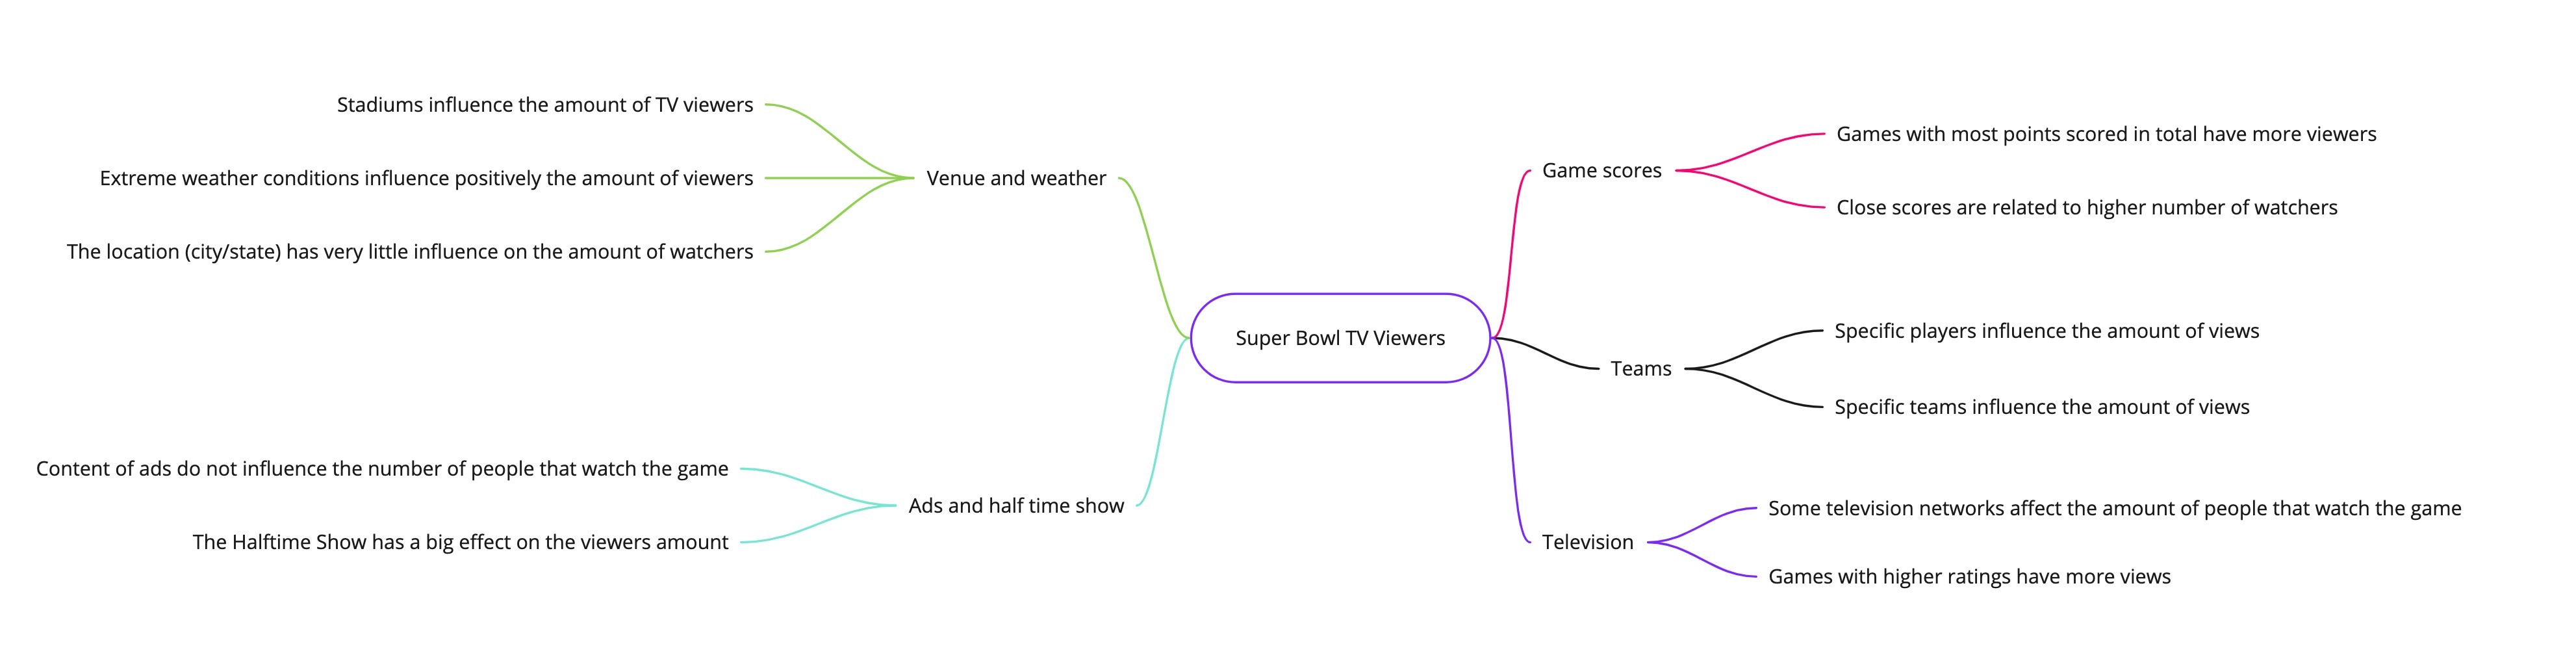

#### Some of the hypothesis will not be checked for the lack of proper data (in red). However, they could be used as suggestions for further development, as per the Readme file.

1. Close scores are related to higher number of watchers
2. Games with most points scored in total have more viewers
3. Specific players influence the amount of views
4. Specific teams influence the amount of views
5. Stadiums influence the amount of TV viewers
6. <span style="color:red">Extreme weather conditions influence positively the amount of viewers</span>
7. The location (city/state) has very little influence on the amount of watchers
8. <span style="color:red">The Halftime Show has a big effect on the viewers amount</span>
9. <span style="color:red">Content of ads do not influence the number of people that watch the game</span>
10. Some television networks affect the amount of people that watch the game
11. Games with higher ratings have more views

### 3.2. Column values

In [24]:
# Edit values in 'TV Vwrs' to have them as numbers

df3['TV Vwrs'] = df3['TV Vwrs'].apply(lambda x: x.replace('M', '').replace('*',''))

In [25]:
# Change column types to ocuppy less memory and run faster

df3[['Year','Winning Pts','Losing Pts', 'Point Difference']] = df3[['Year', 'Winning Pts','Losing Pts',
                                                                    'Point Difference']].astype('int16')
df3[['Rtg','Attendance','TV Vwrs']] = df3[['Rtg','Attendance', 'TV Vwrs']].astype('float32')

In [26]:
# Create a column with the point total of the game

df3['Total Points'] = df3['Winning Pts'] + df3['Losing Pts']

### 3.3. Column names

In [27]:
# Change the name of some columns

df3.columns = ['Year', 'TV Network', 'Nielsen Rating', 'TV Viewers', 'Attendance', 'Winner', 'QB  Winner',
               'Winning points', 'Loser', 'QB Loser','Losing Points', 'MVP', 'Stadium', 'City', 'State',
               'Point Difference','Total Points']

# For more details about Nielsen Ratings: https://en.wikipedia.org/wiki/Nielsen_ratings#Ratings/share_and_total_viewers

In [28]:
# Turns all column names to snakecase

df3.columns = [x.lower().replace(' ', '_') for x in df3.columns]

### 3.4. Dataframe check

In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              55 non-null     int16  
 1   tv_network        55 non-null     object 
 2   nielsen_rating    55 non-null     float32
 3   tv_viewers        55 non-null     float32
 4   attendance        55 non-null     float32
 5   winner            55 non-null     object 
 6   qb__winner        55 non-null     object 
 7   winning_points    55 non-null     int16  
 8   loser             55 non-null     object 
 9   qb_loser          55 non-null     object 
 10  losing_points     55 non-null     int16  
 11  mvp               55 non-null     object 
 12  stadium           55 non-null     object 
 13  city              55 non-null     object 
 14  state             55 non-null     object 
 15  point_difference  55 non-null     int16  
 16  total_points      55 non-null     int16  
dtyp

## **4. EDA**

In [88]:
df4 = df3.copy()

### 4.1. Univariate analysis

#### 4.1.1. Target variable

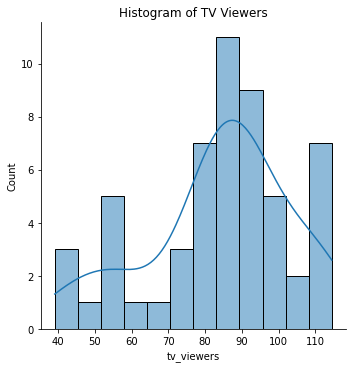

In [90]:
sns.displot(df4['tv_viewers'], bins = 12, kde = True).set(title = 'Histogram of TV Viewers');

#### 4.1.2. Numerical variables

There is a considerable correlation between year and tv viewers. As it is the target variable, this is a good thing. The rest of the data does not show strong signs of multicollinearity, which is a green light.

In [32]:
numerical_variables = df4.select_dtypes( include=['int16', 'float32'])
numerical_variables.columns

Index(['year', 'nielsen_rating', 'tv_viewers', 'attendance', 'winning_points',
       'losing_points', 'point_difference', 'total_points'],
      dtype='object')

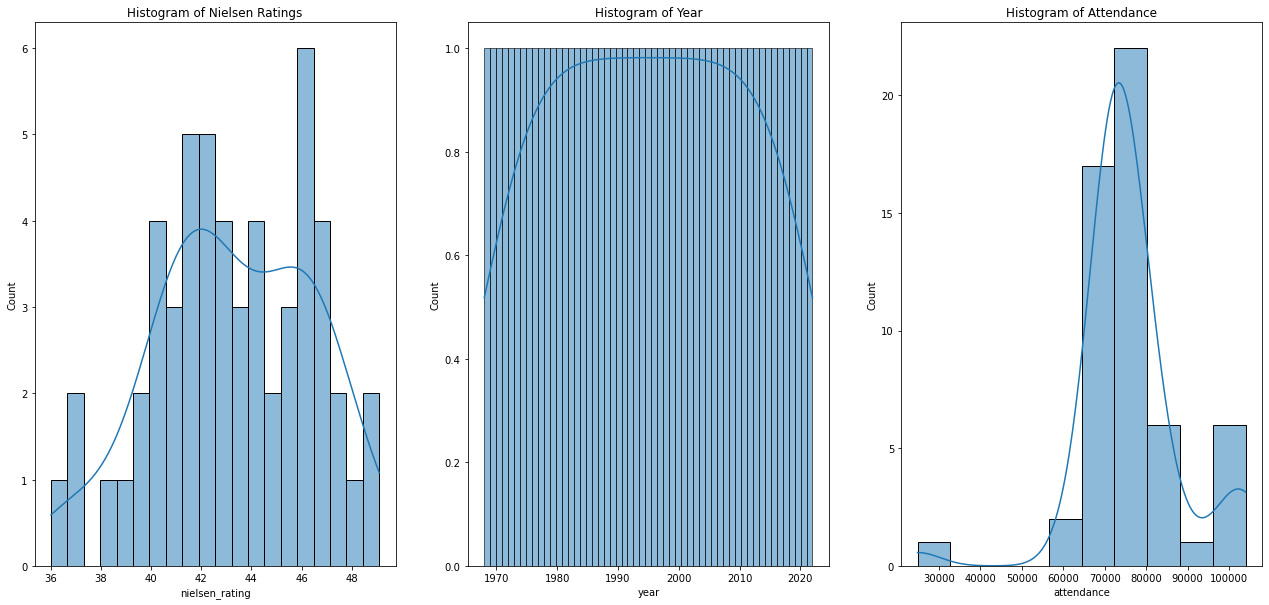

In [92]:
fig = plt.figure(figsize = (22,10))

plt.subplot(1,3,1)
sns.histplot(numerical_variables, x = 'nielsen_rating', kde = True, bins = 20).set(title = 'Histogram of Nielsen Ratings');

plt.subplot(1,3,2)
sns.histplot(numerical_variables, x = 'year', kde = True, bins = 55).set(title = 'Histogram of Year');

plt.subplot(1,3,3)
sns.histplot(numerical_variables, x = 'attendance', kde = True, bins = 10).set(title = 'Histogram of Attendance');

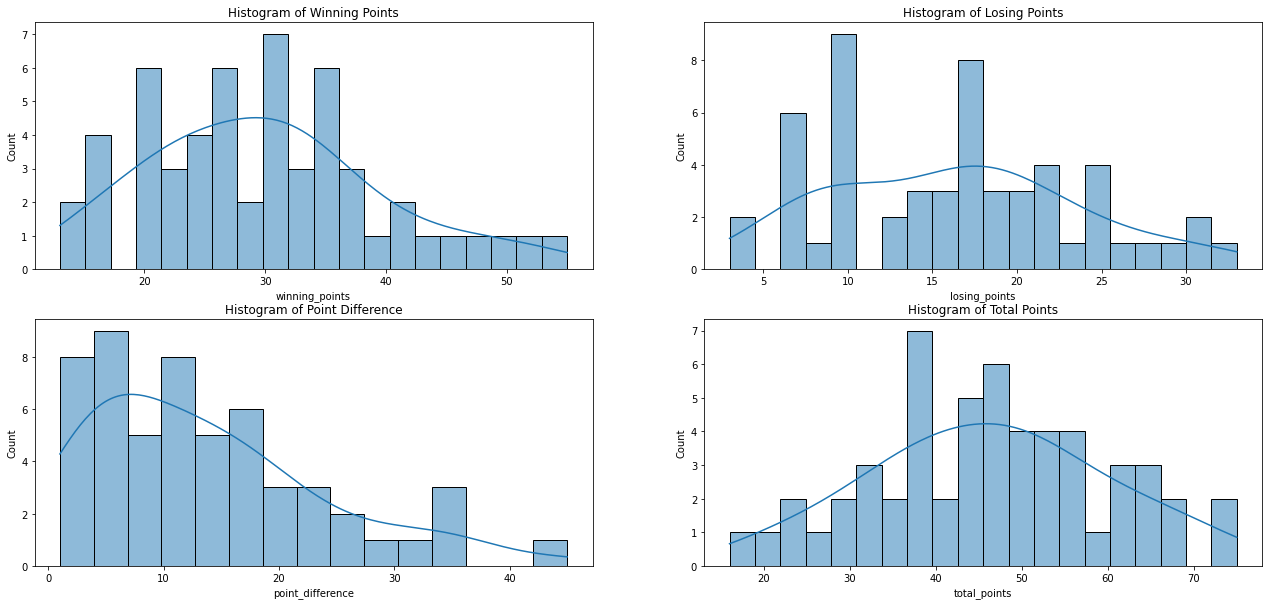

In [93]:
fig = plt.figure(figsize = (22,10))

plt.subplot(2,2,1)
sns.histplot(numerical_variables, x = 'winning_points', kde = True, bins = 20).set(title = 'Histogram of Winning Points');

plt.subplot(2,2,2)
sns.histplot(numerical_variables, x = 'losing_points', kde = True, bins = 20).set(title = 'Histogram of Losing Points');

plt.subplot(2,2,3)
sns.histplot(numerical_variables, x = 'point_difference', kde = True, bins = 15).set(title = 'Histogram of Point Difference');

plt.subplot(2,2,4)
sns.histplot(numerical_variables, x = 'total_points', kde = True, bins = 20).set(title = 'Histogram of Total Points');

#### 4.1.3. Categorical variables

In this section, it is important to note that each variable is being evaluated individually in order to analyze whether they might feed good information to the model. As such, the columns "qb_winner", "qb_loser", "mvp" and stadium" should have very little to offer, since they are very varied. This point will be raised again further on the project, in the "Feature selection" section.

In [35]:
categorical_variables = df4.select_dtypes( include=['object', 'bool'])
categorical_variables.columns

Index(['tv_network', 'winner', 'qb__winner', 'loser', 'qb_loser', 'mvp',
       'stadium', 'city', 'state'],
      dtype='object')

##### 4.1.3.1 Non-location plots

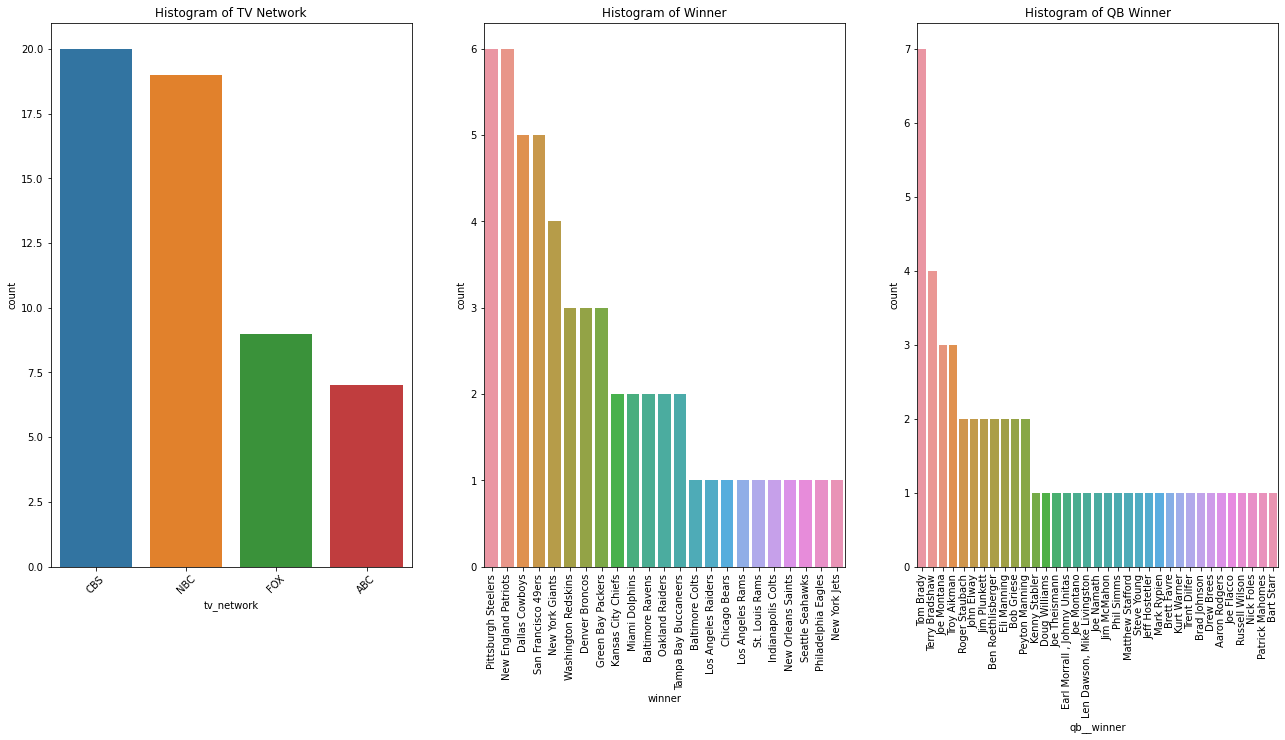

In [95]:
fig = plt.figure(figsize = (22,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['tv_network'], order=categorical_variables['tv_network'].value_counts().index)
plt.title('Histogram of TV Network')
plt.xticks(rotation = 45)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['winner'], order=categorical_variables['winner'].value_counts().index)
plt.title('Histogram of Winner')
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['qb__winner'], order=categorical_variables['qb__winner'].value_counts().index)
plt.title('Histogram of QB Winner')
plt.xticks(rotation = 90);

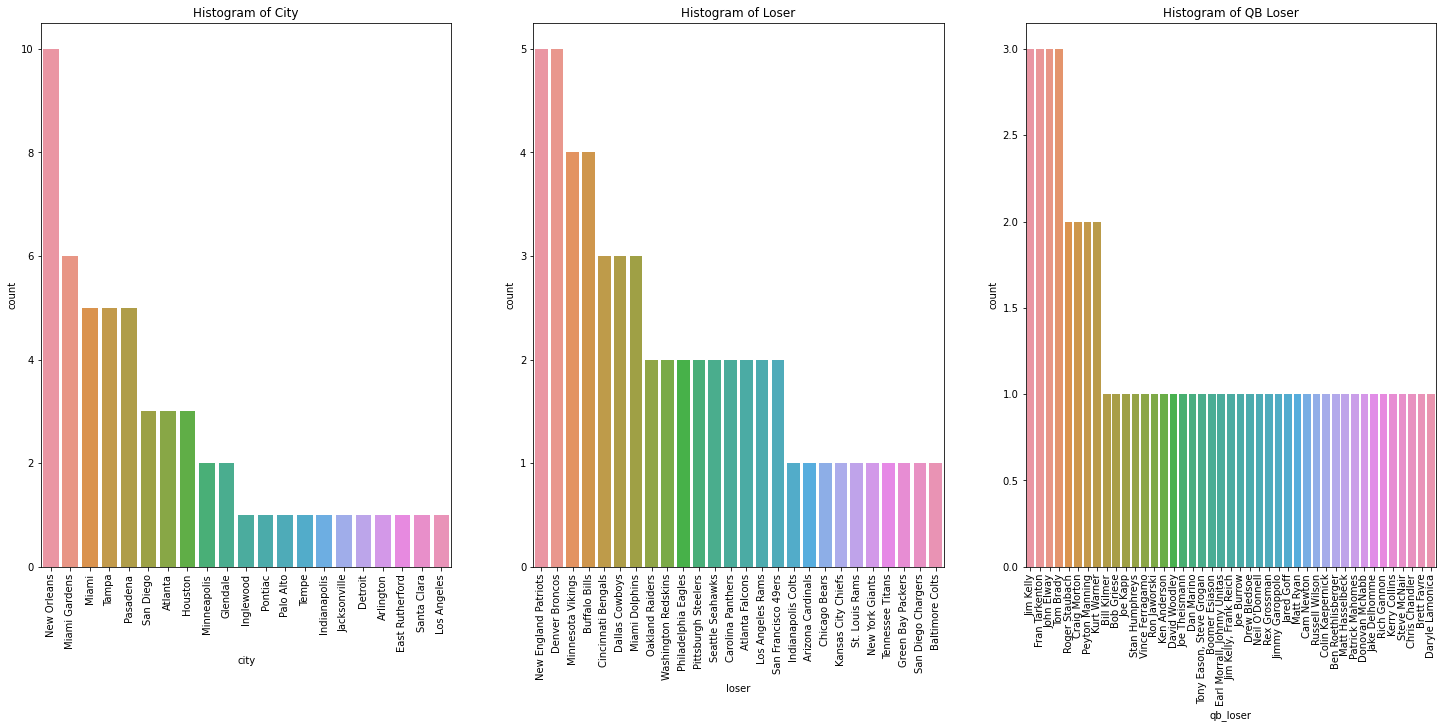

In [97]:
fig = plt.figure(figsize = (25,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['city'], order=categorical_variables['city'].value_counts().index)
plt.title('Histogram of City')
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['loser'], order=categorical_variables['loser'].value_counts().index)
plt.title('Histogram of Loser')
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['qb_loser'], order=categorical_variables['qb_loser'].value_counts().index)
plt.title('Histogram of QB Loser')
plt.xticks(rotation = 90);

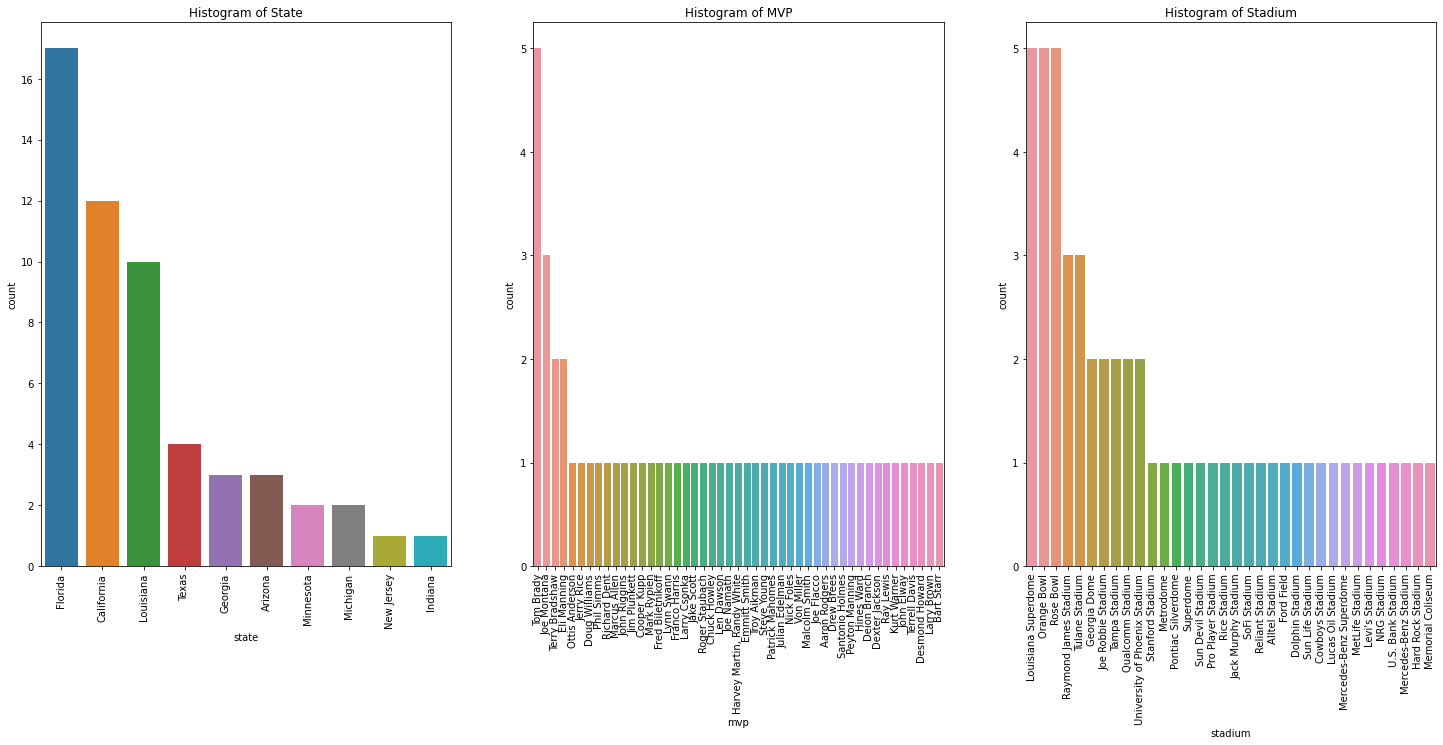

In [98]:
fig = plt.figure(figsize = (25,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['state'], order=categorical_variables['state'].value_counts().index)
plt.title('Histogram of State')
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['mvp'], order=categorical_variables['mvp'].value_counts().index)
plt.title('Histogram of MVP')
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['stadium'], order=categorical_variables['stadium'].value_counts().index)
plt.title('Histogram of Stadium')
plt.xticks(rotation = 90);

##### 4.1.3.2 Location plot

In [39]:
location_data = df4[['state', 'city']]
location_plot1 = location_data[['state', 'city']].groupby('state').count().reset_index()
location_plot1.sort_values(ascending=False, by='city').head(3)

state  city
2     Florida    17
1  California    12
5   Louisiana    10

In [40]:
us_states = pd.read_html('https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/')
us_states = us_states[0]
us_states.columns = ['state','abbreviation','two-letter-code']
us_states.drop([0], axis = 0, inplace = True)
us_states.head(3)

state     abbreviation two-letter-code
1   Alabama             Ala.              AL
2    Alaska  Alaska or Alas.              AK
3  Arkansas             Ark.              AR

In [41]:
location_plot1 = pd.merge(location_plot1, us_states, on="state", how='left')
location_plot1.head(3)

state  city abbreviation two-letter-code
0     Arizona     3        Ariz.              AZ
1  California    12       Calif.              CA
2     Florida    17         Fla.              FL

In [42]:
fig = px.choropleth(location_plot1,
                    locations='two-letter-code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color = 'city',
                    labels={
                     "city": "Super Bowls hosted"},
                    title="Super Bowls hosted by US state",
                    hover_name="state", 
                    hover_data={'two-letter-code':False})
fig.show()

### 4.2. Bivariate analysis

For some of the hypothesis, sadly, the Super Bowl data is not enough. One would need a larger samples to analyze
whether players or teams, for example, raise watchers.

#### 4.2.1. Close scores are related to higher number of watchers

False. Lower point differences do not have higher ratings.

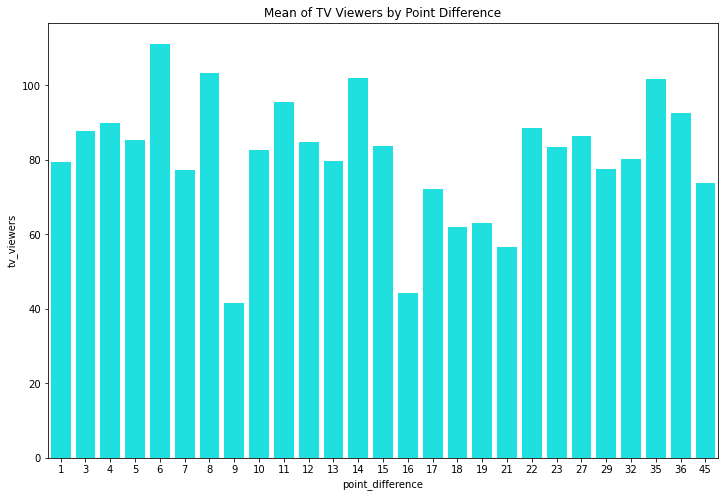

In [100]:
plot_data = df4[['tv_viewers', 'point_difference']].groupby('point_difference').mean().reset_index()

fig = plt.figure(figsize = (12,8))
sns.barplot(data=plot_data, x='point_difference', y='tv_viewers', color = 'cyan')
plt.title('Mean of TV Viewers by Point Difference');

#### 4.2.2. Games with most points scored in total have more viewers

True. Games with very low point totals have fewers views.

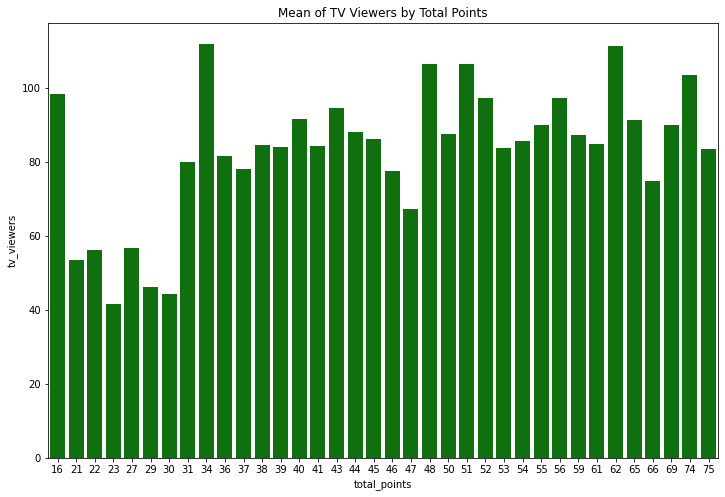

In [101]:
plot_data = df4[['tv_viewers', 'total_points']]
plot_data = plot_data[['tv_viewers', 'total_points']].groupby('total_points').mean().reset_index()

fig = plt.figure(figsize = (12,8))
sns.barplot(data=plot_data, x='total_points', y='tv_viewers', color = 'green')
plt.title('Mean of TV Viewers by Total Points');

#### 4.2.1. 3. Specific players influence the amount of views

Uncertain. **There is a definite trend** here, however, is might also be related to the growth of popularity over the years.

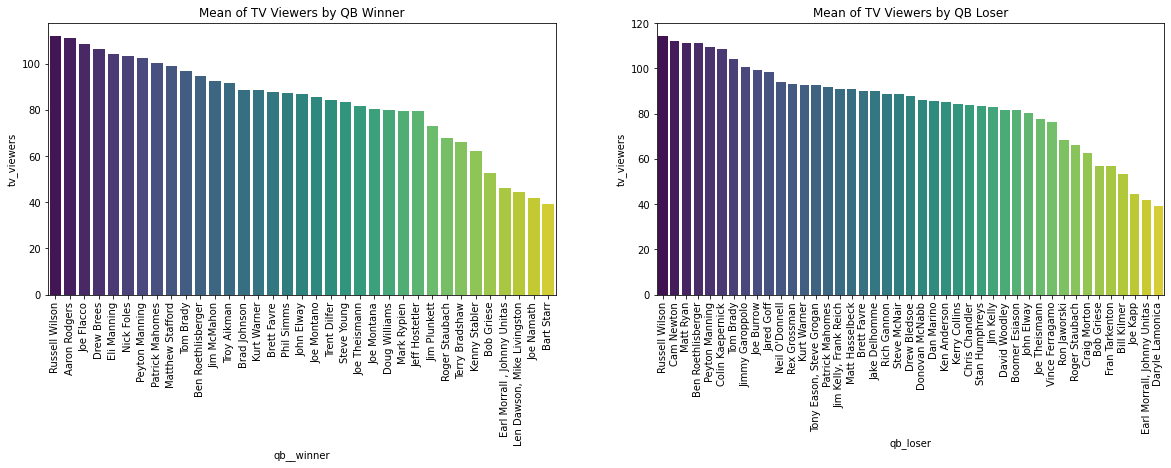

In [102]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plot_data = df4[['tv_viewers', 'qb__winner']].groupby("qb__winner").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'qb__winner', y='tv_viewers', order = plot_data['qb__winner'].tolist(),palette = 'viridis')
plt.title('Mean of TV Viewers by QB Winner')
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plot_data = df4[['tv_viewers', 'qb_loser']].groupby("qb_loser").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'qb_loser', y='tv_viewers', order = plot_data['qb_loser'].tolist(), palette = 'viridis')
plt.title('Mean of TV Viewers by QB Loser')
plt.xticks(rotation = 90);

#### 4.2.4. Specific teams influence the amount of views

Uncertain. Just like in 4.2.3., **there is a trend**, however, is might also be related to the growth of popularity over the years.

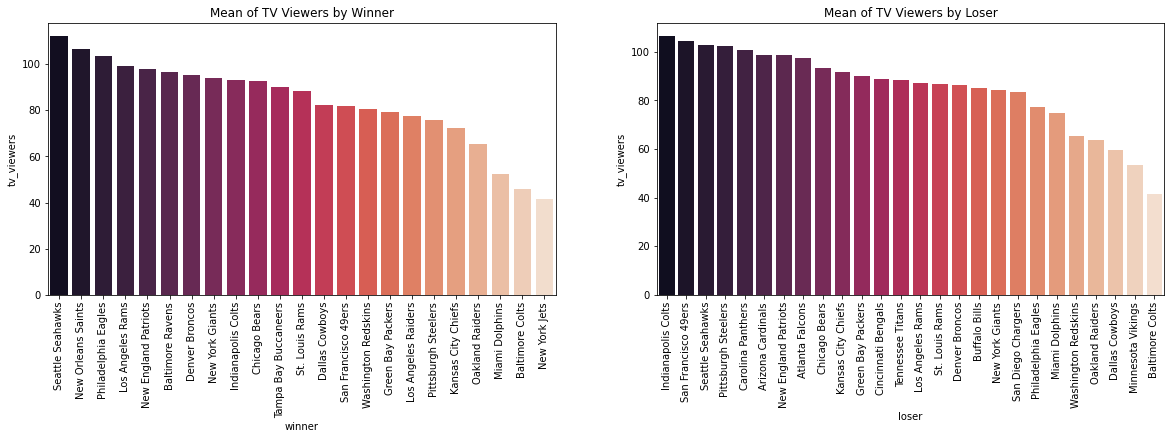

In [113]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plot_data = df4[['tv_viewers', 'winner']].groupby("winner").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'winner', y='tv_viewers', order = plot_data['winner'].tolist(), palette = 'rocket')
plt.title('Mean of TV Viewers by Winner')
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
plot_data = df4[['tv_viewers', 'loser']].groupby("loser").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'loser', y='tv_viewers', order = plot_data['loser'].tolist(), palette = 'rocket')
plt.title('Mean of TV Viewers by Loser')
plt.xticks(rotation = 90);

#### 4.2.5. Stadiums influence the amount of TV viewers

Uncertain. Stadiums seem to influence a more than players or teams with three three distinct tiers: 

    1.Less than 60M;
    2.Less than 95M;
    3.More than 95M.
    
However, this could also be caused by the passage of time.

In [104]:
fig = plt.figure(figsize = (15,20))
plot_data = df4[['tv_viewers', 'stadium']].groupby('stadium').mean().reset_index().sort_values(by = 'tv_viewers')
fig = px.bar(plot_data, x = 'tv_viewers', y = 'stadium', title = 'Mean of TV Viewers by Stadium')
fig.show()

<Figure size 1080x1440 with 0 Axes>

#### 4.2.7. The location (city/state) has very little influence on the amount of watchers

Uncertain, as well. Same interpretation as 4.2.5. (stadiums).

In [105]:
plot_data = df4[['city', 'tv_viewers']].groupby('city').mean().reset_index().sort_values(by='tv_viewers')
fig = px.bar(plot_data, x = 'city', y = 'tv_viewers', title = 'Mean of TV Viewers by City')
fig.show()

#### 4.2.10. Some television networks affect the amount of people that watch the game

True. 'Fox' seems to have a lot more watchers than all the other networks.

In [106]:
plot_data = df4[['tv_viewers', 'tv_network']].groupby('tv_network').mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')

fig = plt.figure(figsize = (12,8))
fig = px.bar(plot_data, x='tv_network', y='tv_viewers', 
             labels = {'tv_viewers' : 'TV viewers', 'tv_network' : 'TV network'},
             hover_name = 'tv_network',
             hover_data = {'tv_network': False}, 
             title = 'Mean of TV Viewers by TV Network')
fig.show()

<Figure size 864x576 with 0 Axes>

#### 4.2.11. Games with higher ratings have more views

True. As expected, the more viewership share a Super Bowl edition has, the more viewers. 

In [108]:
# Create a new column with 'Rtg' values as categories. This would normally be done in 2.2., but
# it would change the category boundaries.

df4['nielsen_rating_categories'] = pd.cut(df4['nielsen_rating'], 5).astype(str)

In [109]:
plot_data = df4[['nielsen_rating_categories', 'tv_viewers']].groupby('nielsen_rating_categories').mean().reset_index().sort_values(ascending = False, by='tv_viewers')
fig = plt.figure(figsize = (12,8))
#sns.barplot(data = plot_data, x = 'nielsen_rating_categories', y='tv_viewers')
fig = px.bar(plot_data, x = 'nielsen_rating_categories', y='tv_viewers', title = 'Mean of TV Viewers by Nielsen Rating Categories')
fig.show()

<Figure size 864x576 with 0 Axes>

### 4.3. Multivariate analysis

#### 4.3.1. Numerical variables

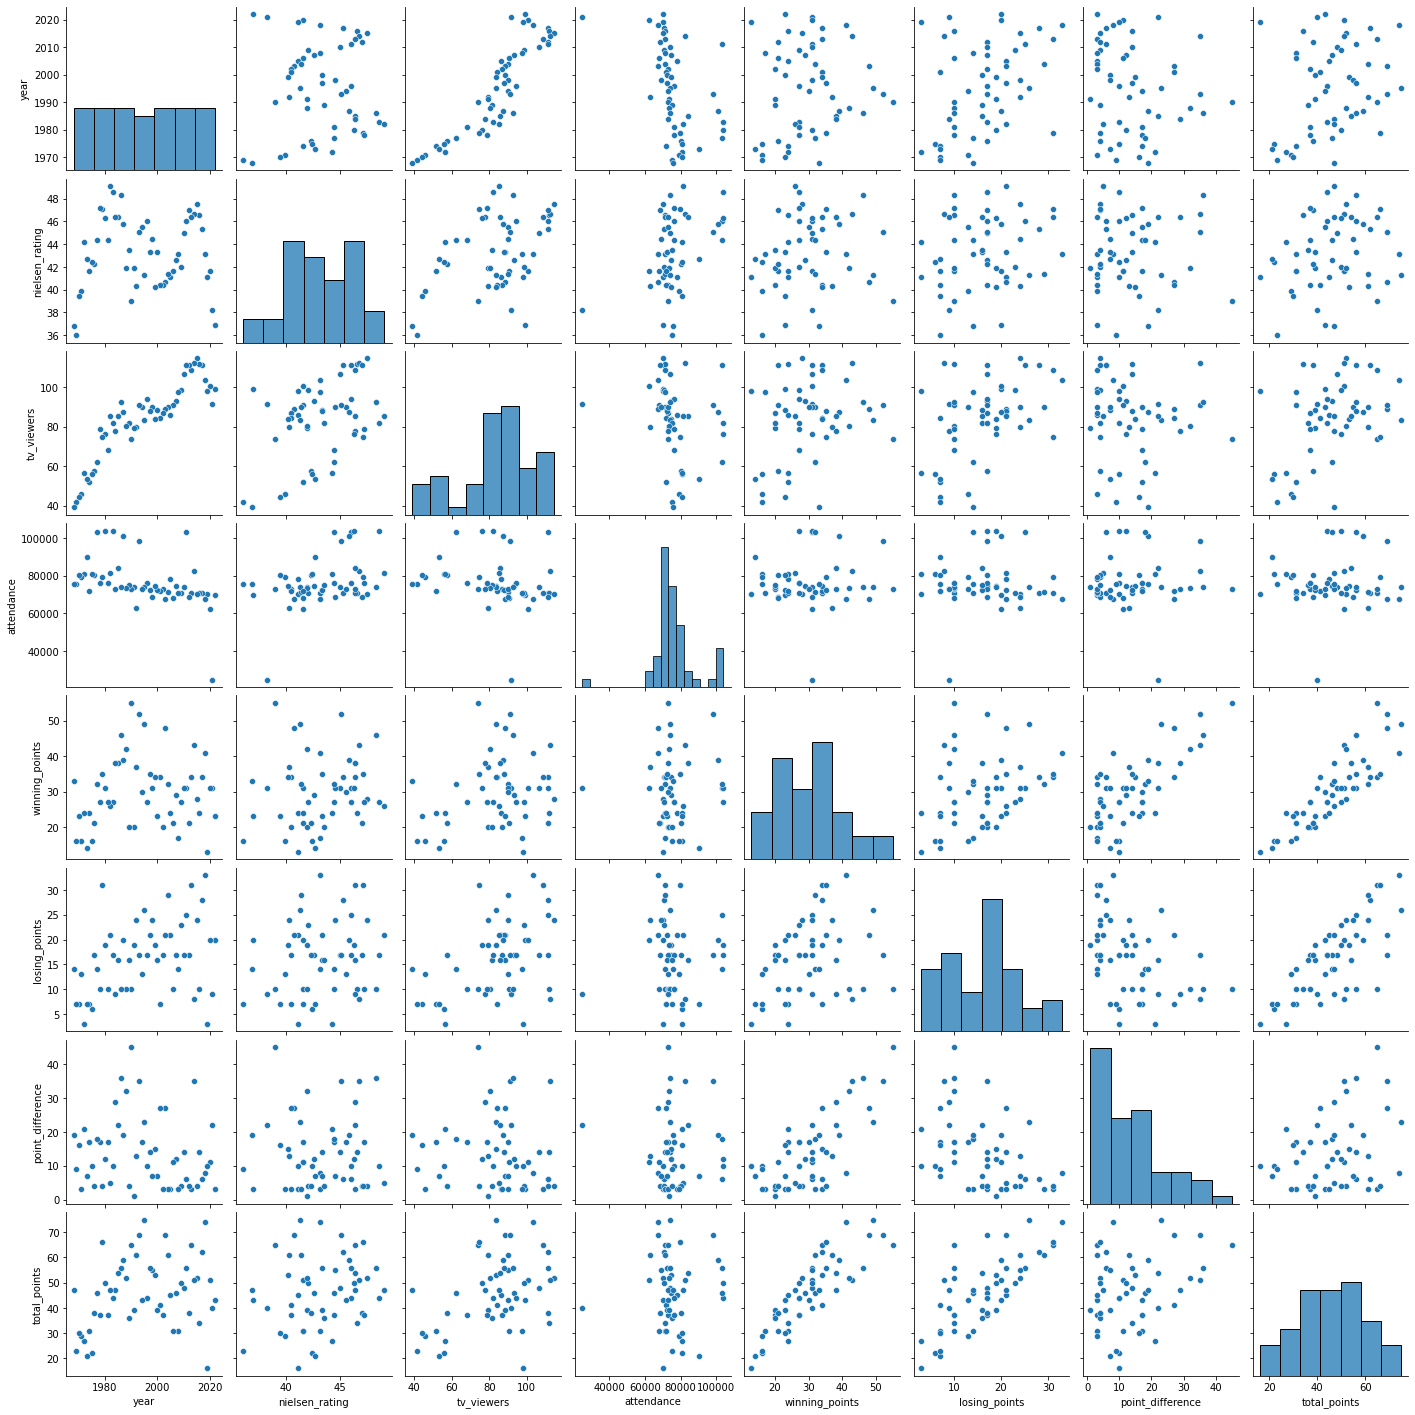

In [52]:
sns.pairplot(numerical_variables);

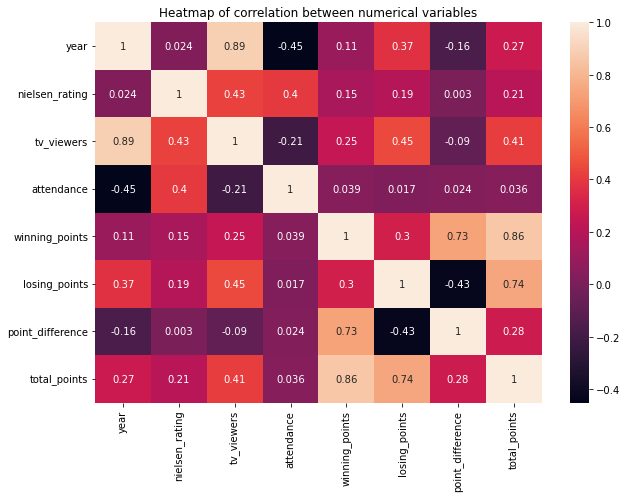

In [111]:
fig = plt.figure(figsize = (10,7))
fig = sns.heatmap(numerical_variables.corr(), annot = True)
plt.title('Heatmap of correlation between numerical variables');

#### 4.3.2. Categorical variables

As shown in the figure below, there is a perfect correlation between a few of those categorical variables:

    -State, city and stadium.

Some other very high correlations were found:

    -MVP, QB winner and winner;
    -QB loser and loser.

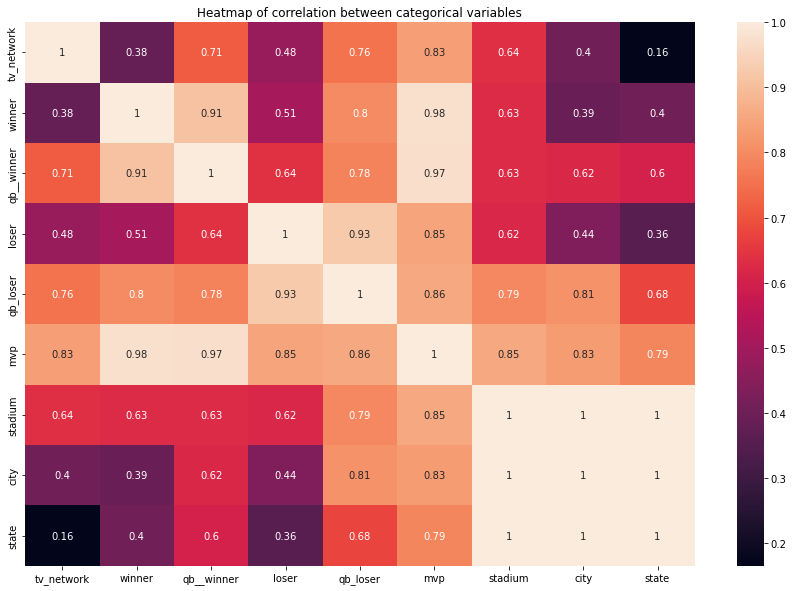

In [112]:
categorical_variables_correlation = build_cramersv_dataframe(categorical_variables)

fig = plt.figure(figsize = (15,10))
sns.heatmap(categorical_variables_correlation, annot = True)
plt.title('Heatmap of correlation between categorical variables');

## 5. DATA PREPARATION

In [55]:
df5 = df4.copy()

### 5.1. Normalization/scaling

In [56]:
sc = StandardScaler()

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df5['nielsen_rating'] = sc.fit_transform(df5[['nielsen_rating']].values)
df5['attendance'] = sc.fit_transform(df5[['nielsen_rating']].values)
df5['winning_points'] = sc.fit_transform(df5[['winning_points']].values)
df5['losing_points'] = sc.fit_transform(df5[['losing_points']].values)
df5['point_difference'] = sc.fit_transform(df5[['point_difference']].values)
df5['total_points'] = sc.fit_transform(df5[['total_points']].values)

In [57]:
df5.describe()

year  nielsen_rating  tv_viewers  attendance  winning_points  \
count   55.000          55.000      55.000      55.000          55.000   
mean  1995.000          -0.000      83.925      -0.000          -0.000   
std     16.021           1.009      19.271       1.009           1.009   
min   1968.000          -2.336      39.120      -2.336          -1.759   
25%   1981.500          -0.665      76.930      -0.665          -0.719   
50%   1995.000          -0.054      86.800      -0.054           0.009   
75%   2008.500           0.877      95.765       0.877           0.478   
max   2022.000           1.874     114.440       1.874           2.611   

       losing_points  point_difference  total_points  
count         55.000            55.000        55.000  
mean           0.000             0.000        -0.000  
std            1.009             1.009         1.009  
min           -1.813            -1.243        -2.199  
25%           -0.855            -0.900        -0.668  
50%            0.102            -0.261        -0.012  
75%            0.649             0.476         0.681  
max            2.290             3.080         2.103

### 5.2. Encoding

In [58]:
df5 = pd.get_dummies(df5,columns = ['tv_network', 'winner','loser','city'], drop_first=True)

In [59]:
df5.shape

(55, 84)

## 6. FEATURE SELECTION

In [60]:
df6 = df5.copy()

In [61]:
# Columns 'qb__winner', 'qb_loser', 'mvp', 'state' and 'stadium' are getting dropped based on the knowledge 
# from 4.2. and 4.3. Column 'nielsen_rating_categories' is being dropped because it was created only for the 
# analyzis in 4.2.11.

y = df6['tv_viewers'].values.ravel()
X = df6.drop(columns = ['tv_viewers','qb__winner', 'qb_loser', 'mvp', 'state', 'stadium', 'nielsen_rating_categories'], axis = 1).values

In [62]:
#https://github.com/scikit-learn-contrib/boruta_py
    
rf = RandomForestRegressor(n_jobs=-1)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	72
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	73
I

BorutaPy(estimator=RandomForestRegressor(n_estimators=28, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FA07DC62940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FA07DC62940, verbose=2)

In [63]:
boruta_selected_columns = df6.drop(columns = ['tv_viewers', 'qb__winner', 'qb_loser', 'mvp', 'state', 'stadium', 'nielsen_rating_categories'], axis = 1).iloc[:, feat_selector.support_.tolist()]
boruta_selected_columns.columns

Index(['year', 'nielsen_rating', 'attendance'], dtype='object')

In [64]:
other_selected_columns = ['point_difference','tv_network_CBS','tv_network_FOX', 'tv_network_NBC']
final_columns = boruta_selected_columns.columns.tolist() + other_selected_columns
final_columns.append('tv_viewers')

In [65]:
df6 = df6.loc[:,final_columns]
df6.shape

(55, 8)

## 7. MODELING

In [66]:
df7 = df6.copy()

In [67]:
y = df7['tv_viewers']
X = df7.drop(['tv_viewers'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 7.1. Baseline

Not a ML model. A model to be used as food for thought: "is using Machine Learning resources really worth it"? In
this case, the answer is clearly yes.

In [68]:
average_predictions = [df7['tv_viewers'].mean() for x in y_test]

In [69]:
baseline_error = error_measures('Average', y_test, average_predictions)
baseline_error

MAE   RMSE    MPE
Average 14.970 18.489 21.455

### 7.2. Linear models

#### 7.2.1. Linear Regressor

In [70]:
# Model creation and error mapping

lr = LinearRegression().fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_error = error_measures('Linear Regression', y_test, lr_predictions)
lr_error

MAE  RMSE   MPE
Linear Regression 3.254 3.623 4.327

In [71]:
# Model score and feature coefficients

print('score:', lr.score(X_train, y_train), '\n')
print(pd.DataFrame(index = lr.feature_names_in_, data = lr.coef_, columns = ['feature_coefficient']))

score: 0.9699669536671578 

                  feature_coefficient
year                            1.046
nielsen_rating          175868231.058
attendance             -175868223.091
point_difference                0.666
tv_network_CBS                 -2.938
tv_network_FOX                 -1.119
tv_network_NBC                 -2.271


#### 7.2.2. Ridge Regressor

In [72]:
# Model creation with cross-validation

model = Ridge()
parameters = {'alpha':[0.1, 1, 10]}
ridge = GridSearchCV(model, parameters, cv=5, verbose=3)
ridge.fit(X_train ,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .........................alpha=0.1;, score=0.972 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.894 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.851 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.928 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.991 total time=   0.0s
[CV 1/5] END ...........................alpha=1;, score=0.973 total time=   0.0s
[CV 2/5] END ...........................alpha=1;, score=0.893 total time=   0.0s
[CV 3/5] END ...........................alpha=1;, score=0.846 total time=   0.0s
[CV 4/5] END ...........................alpha=1;, score=0.932 total time=   0.0s
[CV 5/5] END ...........................alpha=1;, score=0.991 total time=   0.0s
[CV 1/5] END ..........................alpha=10;, score=0.975 total time=   0.0s
[CV 2/5] END ..........................alpha=10;,

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.1, 1, 10]},
             verbose=3)

In [73]:
# Error mapping

ridge_predictions = ridge.predict(X_test)
ridge_error = error_measures('Ridge', y_test, ridge_predictions)
ridge_error

MAE  RMSE   MPE
Ridge 3.214 3.532 4.282

In [74]:
# Model score, best estimator and feature coefficients

print('score:', ridge.score(X_train, y_train), '\n')
print('best estimator:', ridge.best_estimator_, '\n')
print(pd.DataFrame(index = lr.feature_names_in_, data = Ridge(alpha=0.1).fit(X_train, y_train).coef_,
                   columns = ['feature_coefficient']))

score: 0.9696573702433925 

best estimator: Ridge(alpha=0.1) 

                  feature_coefficient
year                            1.044
nielsen_rating                  3.973
attendance                      3.973
point_difference                0.735
tv_network_CBS                 -2.505
tv_network_FOX                 -0.944
tv_network_NBC                 -1.917


### 7.3. Ensemble models

#### 7.3.1. Random Forest Regressor

In [75]:
# Model creation with cross-validation

model = RandomForestRegressor()
parameters = {'bootstrap': [True, False],
              'max_depth': [10, 50, 100, None],
              'max_features': ['auto', 'sqrt'],
              'n_estimators': [500, 1000, 2000]}
rf = GridSearchCV(model, parameters, cv=5, verbose=3)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.973 total time=   0.6s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.933 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.779 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.767 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.948 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.968 total time=   1.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.931 total time=   1.0s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.783 total time=   1.0s
[CV 4/5] END bootstrap=True, max_depth=

[CV 4/5] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=2000;, score=0.773 total time=   1.9s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=2000;, score=0.949 total time=   1.9s
[CV 1/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.714 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.526 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.050 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.884 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.726 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=1000;, score=0.713 total time=   0.9s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=1000;, score=0.56

[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.782 total time=   1.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.486 total time=   1.4s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=-0.197 total time=   1.6s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.876 total time=   1.7s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.797 total time=   1.5s
[CV 1/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.939 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.876 total time=   0.4s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.813 total time=   0.4s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.

[CV 3/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.813 total time=   0.8s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.728 total time=   0.9s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.980 total time=   0.9s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.939 total time=   2.0s
[CV 2/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.877 total time=   1.7s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.814 total time=   1.6s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.724 total time=   1.9s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.980 total time=   1.6s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=sqrt, n_estim

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [500, 1000, 2000]},
             verbose=3)

In [76]:
# Error mapping

rf_predictions = rf.predict(X_test)
rf_error = error_measures('Random Forest Regressor', y_test, rf_predictions)
rf_error

MAE  RMSE   MPE
Random Forest Regressor 4.414 5.501 5.750

In [77]:
# Best parameters and feature importances

print('best parameters:', rf.best_params_, '\n')
print(pd.DataFrame(index = rf.feature_names_in_, 
                   data = RandomForestRegressor(bootstrap = True, max_depth = 50, max_features= 'auto',n_estimators = 1000)
                   .fit(X_train, y_train).feature_importances_, columns = ['feature_importante']))

best parameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000} 

                  feature_importante
year                           0.932
nielsen_rating                 0.029
attendance                     0.028
point_difference               0.006
tv_network_CBS                 0.003
tv_network_FOX                 0.000
tv_network_NBC                 0.002


#### 7.3.2. Extra trees Regressor

In [78]:
# Model creation with cross-validation

model = ExtraTreesRegressor()
parameters = {'bootstrap': [True, False],
              'max_depth': [10, 50, 100, None],
              'max_features': ['auto', 'sqrt'],
              'n_estimators': [500, 1000, 2000]}
et = GridSearchCV(model, parameters, cv=5, verbose=3)
et.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.927 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.950 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.873 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.939 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=500;, score=0.943 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.899 total time=   0.9s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.959 total time=   1.1s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=1000;, score=0.867 total time=   1.3s
[CV 4/5] END bootstrap=True, max_depth=

[CV 4/5] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=2000;, score=0.941 total time=   1.8s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=2000;, score=0.941 total time=   1.9s
[CV 1/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.616 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.685 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.407 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.846 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=500;, score=0.704 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=1000;, score=0.641 total time=   0.9s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=sqrt, n_estimators=1000;, score=0.66

[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.738 total time=   1.3s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.792 total time=   1.3s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.292 total time=   1.3s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.879 total time=   1.3s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=2000;, score=0.794 total time=   1.3s
[CV 1/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.969 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.962 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.895 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=500;, score=0.9

[CV 3/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.895 total time=   0.7s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.926 total time=   0.7s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000;, score=0.968 total time=   0.8s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.969 total time=   1.5s
[CV 2/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.964 total time=   1.5s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.891 total time=   1.4s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.918 total time=   1.5s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=2000;, score=0.967 total time=   1.7s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=sqrt, n_estim

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [500, 1000, 2000]},
             verbose=3)

In [79]:
# Error mapping

et_predictions = et.predict(X_test)
et_error = error_measures('Extra Trees Regressor', y_test, et_predictions)
et_error

MAE  RMSE   MPE
Extra Trees Regressor 2.683 2.968 3.258

In [80]:
# Best parameters and feature importances

print('best parameters:', et.best_params_, '\n')
print(pd.DataFrame(index = et.feature_names_in_, 
                   data = ExtraTreesRegressor(bootstrap = False, max_depth = 100, max_features= 'auto',n_estimators = 1000)
                   .fit(X_train, y_train).feature_importances_, columns = ['feature_importante']))

best parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 2000} 

                  feature_importante
year                           0.768
nielsen_rating                 0.100
attendance                     0.106
point_difference               0.010
tv_network_CBS                 0.006
tv_network_FOX                 0.004
tv_network_NBC                 0.006


#### 7.3.3. XGBoost Regressor

In [81]:
# Model creation with cross-validation

model = XGBRegressor(objective='reg:squarederror')
parameters = {'n_estimators': [500, 1000, 2000],
              'max_depth': [10, 50, 100, None],
              'reg_alpha': [0.1, 1, 10],
              'reg_lambda': [0.1, 1 ,10]}
xgb = GridSearchCV(model, parameters, cv=5, verbose=3)
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1;, score=0.922 total time=   0.2s
[CV 2/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1;, score=0.880 total time=   0.1s
[CV 3/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV 4/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1;, score=0.770 total time=   0.2s
[CV 5/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1;, score=0.962 total time=   0.2s
[CV 1/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=1;, score=0.829 total time=   0.2s
[CV 2/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=1;, score=0.890 total time=   0.1s
[CV 3/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=1;, score=0.826 total time=   0.2s
[CV 4/5] END max_depth=10, n_estimators=500, reg_alpha=0.1, reg_lambda=1;, scor

[CV 4/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=0.1;, score=0.768 total time=   0.2s
[CV 5/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=0.1;, score=0.942 total time=   0.2s
[CV 1/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=1;, score=0.798 total time=   0.2s
[CV 2/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=1;, score=0.874 total time=   0.2s
[CV 3/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=1;, score=0.909 total time=   0.2s
[CV 4/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=1;, score=0.766 total time=   0.2s
[CV 5/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=1;, score=0.950 total time=   0.3s
[CV 1/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=10;, score=0.806 total time=   0.5s
[CV 2/5] END max_depth=10, n_estimators=1000, reg_alpha=10, reg_lambda=10;, score=0.858 total time=   0.4s
[CV 3/5] END max_depth=10, n_estimators=

[CV 3/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=1;, score=0.844 total time=   0.1s
[CV 4/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=1;, score=0.826 total time=   0.1s
[CV 5/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=1;, score=0.946 total time=   0.1s
[CV 1/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=10;, score=0.798 total time=   0.1s
[CV 2/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=10;, score=0.924 total time=   0.1s
[CV 3/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=10;, score=0.806 total time=   0.1s
[CV 4/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=10;, score=0.613 total time=   0.1s
[CV 5/5] END max_depth=50, n_estimators=500, reg_alpha=1, reg_lambda=10;, score=0.943 total time=   0.1s
[CV 1/5] END max_depth=50, n_estimators=500, reg_alpha=10, reg_lambda=0.1;, score=0.834 total time=   0.1s
[CV 2/5] END max_depth=50, n_estimators=500, reg_alpha=1

[CV 5/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=1;, score=0.952 total time=   0.4s
[CV 1/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=10;, score=0.828 total time=   0.4s
[CV 2/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=10;, score=0.922 total time=   0.4s
[CV 3/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=10;, score=0.801 total time=   0.4s
[CV 4/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=10;, score=0.621 total time=   1.0s
[CV 5/5] END max_depth=50, n_estimators=2000, reg_alpha=0.1, reg_lambda=10;, score=0.945 total time=   0.4s
[CV 1/5] END max_depth=50, n_estimators=2000, reg_alpha=1, reg_lambda=0.1;, score=0.896 total time=   0.4s
[CV 2/5] END max_depth=50, n_estimators=2000, reg_alpha=1, reg_lambda=0.1;, score=0.877 total time=   0.4s
[CV 3/5] END max_depth=50, n_estimators=2000, reg_alpha=1, reg_lambda=0.1;, score=0.911 total time=   0.4s
[CV 4/5] END max_depth=50, n_est

[CV 2/5] END max_depth=100, n_estimators=500, reg_alpha=10, reg_lambda=10;, score=0.858 total time=   0.1s
[CV 3/5] END max_depth=100, n_estimators=500, reg_alpha=10, reg_lambda=10;, score=0.865 total time=   0.1s
[CV 4/5] END max_depth=100, n_estimators=500, reg_alpha=10, reg_lambda=10;, score=0.650 total time=   0.1s
[CV 5/5] END max_depth=100, n_estimators=500, reg_alpha=10, reg_lambda=10;, score=0.950 total time=   0.1s
[CV 1/5] END max_depth=100, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.922 total time=   0.5s
[CV 2/5] END max_depth=100, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.880 total time=   0.4s
[CV 3/5] END max_depth=100, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.879 total time=   0.3s
[CV 4/5] END max_depth=100, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.770 total time=   0.1s
[CV 5/5] END max_depth=100, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.962 total time=   0.2s
[CV 1/5] END max_depth

[CV 3/5] END max_depth=100, n_estimators=2000, reg_alpha=1, reg_lambda=10;, score=0.806 total time=   0.3s
[CV 4/5] END max_depth=100, n_estimators=2000, reg_alpha=1, reg_lambda=10;, score=0.613 total time=   0.3s
[CV 5/5] END max_depth=100, n_estimators=2000, reg_alpha=1, reg_lambda=10;, score=0.943 total time=   0.3s
[CV 1/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=0.1;, score=0.834 total time=   0.3s
[CV 2/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=0.1;, score=0.848 total time=   0.3s
[CV 3/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=0.1;, score=0.900 total time=   0.3s
[CV 4/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=0.1;, score=0.768 total time=   0.3s
[CV 5/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=0.1;, score=0.942 total time=   0.3s
[CV 1/5] END max_depth=100, n_estimators=2000, reg_alpha=10, reg_lambda=1;, score=0.798 total time=   0.3s
[CV 2/5] END max_depth=100,

[CV 4/5] END max_depth=None, n_estimators=1000, reg_alpha=0.1, reg_lambda=10;, score=0.620 total time=   0.2s
[CV 5/5] END max_depth=None, n_estimators=1000, reg_alpha=0.1, reg_lambda=10;, score=0.947 total time=   0.2s
[CV 1/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=0.1;, score=0.896 total time=   0.1s
[CV 2/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=0.1;, score=0.877 total time=   0.3s
[CV 3/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=0.1;, score=0.911 total time=   0.4s
[CV 4/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=0.1;, score=0.802 total time=   0.4s
[CV 5/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=0.1;, score=0.962 total time=   0.2s
[CV 1/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=1;, score=0.809 total time=   0.2s
[CV 2/5] END max_depth=None, n_estimators=1000, reg_alpha=1, reg_lambda=1;, score=0.860 total time=   0.2s
[CV 3/5] END max_dept

[CV 5/5] END max_depth=None, n_estimators=2000, reg_alpha=10, reg_lambda=10;, score=0.950 total time=   0.3s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...ep=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                          

In [82]:
# Error mapping

xgb_predictions = xgb.predict(X_test)
xgb_error = error_measures('XGB Regressor', y_test, xgb_predictions)
xgb_error

MAE  RMSE   MPE
XGB Regressor 3.731 4.644 4.821

In [83]:
# Best parameters and feature importances

print('best parameters:', xgb.best_params_, '\n')
print(pd.DataFrame(index = xgb.feature_names_in_, 
                   data = XGBRegressor(objective='reg:squarederror',max_depth = None, n_estimators = 500, reg_alpha = 1, reg_lambda = 0.1)
                   .fit(X_train, y_train).feature_importances_, columns = ['feature_importances']))

best parameters: {'max_depth': None, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 0.1} 

                  feature_importances
year                            0.933
nielsen_rating                  0.062
attendance                      0.000
point_difference                0.003
tv_network_CBS                  0.001
tv_network_FOX                  0.000
tv_network_NBC                  0.000


### 7.4. Error summary and model choice

In [84]:
# Not only the Extra Trees Regressor showed better error metrics, among the non-linear models it was also better
# balanced between the features.

error_df = pd.concat([baseline_error, lr_error, ridge_error, rf_error, et_error, xgb_error]).sort_values(by='MPE')
error_df

MAE   RMSE    MPE
Extra Trees Regressor    2.683  2.968  3.258
Ridge                    3.214  3.532  4.282
Linear Regression        3.254  3.623  4.327
XGB Regressor            3.731  4.644  4.821
Random Forest Regressor  4.414  5.501  5.750
Average                 14.970 18.489 21.455

In [85]:
model_error_data = pd.DataFrame({'Test values': y_test,'Model predictions': et_predictions})
model_error_data.sort_index(inplace=True)
model_error_data['Error'] = np.abs(model_error_data['Test values'] - model_error_data['Model predictions'])
model_error_data

Test values  Model predictions  Error
3        98.190             94.674  3.516
5       111.320            107.412  3.908
12      106.480            102.154  4.326
13       98.730             97.025  1.705
19       88.640             85.824  2.816
26       94.080             92.433  1.647
31       79.510             83.014  3.504
32       73.850             76.864  3.014
33       81.590             84.232  2.642
34       80.140             79.937  0.203
41       68.290             71.231  2.941
43       74.740             79.451  4.711
49       53.320             55.234  1.914
52       44.270             44.989  0.719

In [86]:
import plotly.graph_objects as go
#fig.data = []

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Super Bowl TV Viewers: Observed vs Predicted"),
                                 hovermode = 'x unified'))

fig.add_trace(go.Scatter(x=model_error_data.index, y=model_error_data['Test values'],mode='lines',name='Observed'))

fig.add_trace(go.Scatter(x=model_error_data.index, y=model_error_data['Model predictions'], mode='lines', name='Predicted'))

fig.show()

## 8.0 SAVE MODEL FOR DEPLOYMENT

In [87]:
model = "Extra Trees Regressor_Model.pkl"

with open(model, 'wb') as file:  
    pickle.dump(et, file)